In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchinfo import summary
from sklearn.metrics import accuracy_score
# from PIL import Image

In [2]:
styles = pd.read_csv("../data/myntradataset/styles.csv", error_bad_lines = False)
styles

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


# Modelling - masterCategory

## Data preparation

In [8]:
dropped_cols = ["gender", "season", "year", "usage", "productDisplayName"]
styles_subset = styles.drop(dropped_cols, axis=1)
styles_subset.to_csv("../data/styles_subset.csv", index=False)
styles_subset

,id,masterCategory,subCategory,articleType,baseColour
0,15970,Apparel,Topwear,Shirts,Navy Blue
1,39386,Apparel,Bottomwear,Jeans,Blue
2,59263,Accessories,Watches,Watches,Silver
3,21379,Apparel,Bottomwear,Track Pants,Black
4,53759,Apparel,Topwear,Tshirts,Grey
...,...,...,...,...,...
44419,17036,Footwear,Shoes,Casual Shoes,White
44420,6461,Footwear,Flip Flops,Flip Flops,Red
44421,18842,Apparel,Topwear,Tshirts,Blue
44422,46694,Personal Care,Fragrance,Perfume and Body Mist,Blue


In [12]:
styles_subset["masterCategory"].value_counts()

Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: masterCategory, dtype: int64

In [20]:
# creating train and test data with equal proportions of masterCategory
# Home has only 1 sample, using that for train
y = styles_subset[styles_subset["masterCategory"] != "Home"]["masterCategory"]
train, test = train_test_split(styles_subset[styles_subset["masterCategory"] != "Home"], test_size=0.2, stratify=y)

In [31]:
# the single sample for "Home" appended to train 
train = train.append(styles_subset[styles_subset["masterCategory"] == "Home"])

In [32]:
train["masterCategory"].value_counts()

Apparel           17118
Accessories        9019
Footwear           7375
Personal Care      1922
Free Items           84
Sporting Goods       20
Home                  1
Name: masterCategory, dtype: int64

In [33]:
test["masterCategory"].value_counts()

Apparel           4279
Accessories       2255
Footwear          1844
Personal Care      481
Free Items          21
Sporting Goods       5
Name: masterCategory, dtype: int64

In [34]:
train.to_csv("../data/train_mc.csv", index=False)
test.to_csv("../data/test_mc.csv", index=False)

In [53]:
# function to split images by target class
def split_subdirs(csv_file_path, source_dir, target_dir):
    df = pd.read_csv(csv_file_path)

    for index, row in df.iterrows():
        image_filename = str(row["id"]) + ".jpg"  
        class_label = row["masterCategory"]

        target_directory = os.path.join(target_dir, str(class_label))

        os.makedirs(target_directory, exist_ok=True)

        source_file_path = os.path.join(source_dir, image_filename)
        target_file_path = os.path.join(target_directory, image_filename)

        try:
            shutil.copy(source_file_path, target_file_path)
            
        except shutil.Error as e:
            print("Shutil error", e)
        
        except Exception as e:
            print("Error", e)

    print("Image movement completed.")

In [2]:
# splitting train and test images by  masterCategory
csv_file_path = "../data/styles_subset.csv"
source_dir = "../data/myntradataset/images/"
mc_root_dir = "../data/mc"
train_dir = os.path.join(mc_root_dir, "train")
test_dir = os.path.join(mc_root_dir, "test")

split_subdirs(csv_file_path, source_dir, train_dir)
split_subdirs(csv_file_path, source_dir, test_dir)

In [6]:
for dirpath, dirnames, filenames in os.walk(mc_root_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '../data/mc'.
There are 6 directories and 0 images in '../data/mc/test'.
There are 0 directories and 17 images in '../data/mc/test/Free Items'.
There are 0 directories and 1694 images in '../data/mc/test/Accessories'.
There are 0 directories and 4 images in '../data/mc/test/Sporting Goods'.
There are 0 directories and 3173 images in '../data/mc/test/Apparel'.
There are 0 directories and 1385 images in '../data/mc/test/Footwear'.
There are 0 directories and 356 images in '../data/mc/test/Personal Care'.
There are 0 directories and 0 images in '../data/mc/.ipynb_checkpoints'.
There are 7 directories and 0 images in '../data/mc/train'.
There are 0 directories and 84 images in '../data/mc/train/Free Items'.
There are 0 directories and 9019 images in '../data/mc/train/Accessories'.
There are 0 directories and 20 images in '../data/mc/train/Sporting Goods'.
There are 0 directories and 1 images in '../data/mc/train/Home'.
There are 0 directories and 171

# Modelling

In [3]:
tsfm = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor() 
])

In [4]:
# datasets from ImageFolder
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=tsfm, 
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=tsfm)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 35535
    Root location: ../data/mc/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 6629
    Root location: ../data/mc/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [5]:
train_data.classes, train_data.class_to_idx

(['Accessories',
  'Apparel',
  'Footwear',
  'Free Items',
  'Home',
  'Personal Care',
  'Sporting Goods'],
 {'Accessories': 0,
  'Apparel': 1,
  'Footwear': 2,
  'Free Items': 3,
  'Home': 4,
  'Personal Care': 5,
  'Sporting Goods': 6})

In [6]:
# DataLoaders
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=32,
                              shuffle=True) 

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=32, 
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f62016f8190>,
 <torch.utils.data.dataloader.DataLoader at 0x7f62016f8a50>)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Tranfer Learning - resnet50

In [12]:
mc_model = models.resnet50(pretrained=True).to(device)
    
for param in mc_model.parameters():
    param.requires_grad = False   
    
# custom classifier layers
mc_model.fc = torch.nn.Sequential(
               torch.nn.Linear(2048, 128),
               torch.nn.ReLU(),
               torch.nn.ReLU(inplace=True),
               torch.nn.Linear(128, 7)).to(device)

In [13]:
summary(model=mc_model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 7]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mc_model.parameters())

In [25]:
num_epochs = 10
best_test_accuracy = 0
for epoch in range(num_epochs):
    mc_model.train()
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = mc_model(inputs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mc_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device) 
            outputs = mc_model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    
    # Print test accuracy
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {test_accuracy:.4f}')

    # Check if the current test accuracy is the best
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        # Save the mc_model with the highest test accuracy
        best_model_path = '../models/mc_model.pth'
        torch.save(mc_model.state_dict(), best_model_path)
        print(f'mc_model saved with highest test accuracy: {best_model_path}')

Epoch 1/10, Test Accuracy: 0.9214
mc_model saved with highest test accuracy: ../models/mc_model.pth
Epoch 2/10, Test Accuracy: 0.9264
mc_model saved with highest test accuracy: ../models/mc_model.pth
Epoch 3/10, Test Accuracy: 0.9243
Epoch 4/10, Test Accuracy: 0.9247
Epoch 5/10, Test Accuracy: 0.9317
mc_model saved with highest test accuracy: ../models/mc_model.pth
Epoch 6/10, Test Accuracy: 0.9203
Epoch 7/10, Test Accuracy: 0.9311
Epoch 8/10, Test Accuracy: 0.9280
Epoch 9/10, Test Accuracy: 0.9270
Epoch 10/10, Test Accuracy: 0.9306


## Transfer learning - resnet18

In [8]:
mc_model_18 = models.resnet18(pretrained=True).to(device)
    
for param in mc_model_18.parameters():
    param.requires_grad = False   
    
mc_model_18.fc = torch.nn.Sequential(
               torch.nn.Linear(512, 7)).to(device)

In [9]:
summary(model=mc_model_18, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 7]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mc_model_18.parameters())

In [13]:
num_epochs = 10
best_test_accuracy = 0
for epoch in range(num_epochs):
    mc_model_18.train()
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = mc_model_18(inputs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mc_model_18.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device) 
            outputs = mc_model_18(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    
    # Print test accuracy
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {test_accuracy:.4f}')

    # Check if the current test accuracy is the best
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        # Save the mc_model_18 with the highest test accuracy
        best_model_path = '../models/mc_model_18.pth'
        torch.save(mc_model_18.state_dict(), best_model_path)
        print(f'mc_model_18 saved with highest test accuracy: {best_model_path}')

Epoch 1/10, Test Accuracy: 0.9161
mc_model_18 saved with highest test accuracy: ../models/mc_model_18.pth
Epoch 2/10, Test Accuracy: 0.9154
Epoch 3/10, Test Accuracy: 0.9178
mc_model_18 saved with highest test accuracy: ../models/mc_model_18.pth
Epoch 4/10, Test Accuracy: 0.9217
mc_model_18 saved with highest test accuracy: ../models/mc_model_18.pth
Epoch 5/10, Test Accuracy: 0.9214
Epoch 6/10, Test Accuracy: 0.9185
Epoch 7/10, Test Accuracy: 0.9178
Epoch 8/10, Test Accuracy: 0.9191
Epoch 9/10, Test Accuracy: 0.9197
Epoch 10/10, Test Accuracy: 0.9203


## Custom model architecture

In [62]:
tsfm = transforms.Compose([
    transforms.Resize(size=(80, 60)),
    transforms.ToTensor() 
])

In [28]:
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=tsfm, 
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=tsfm)

In [29]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=32,
                              shuffle=True) 

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=32, 
                             shuffle=False)

In [42]:
custom_model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),

    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),

    torch.nn.Flatten(),

    torch.nn.Linear(32*18*13, 64),
    torch.nn.ReLU(),

    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),

    torch.nn.Linear(32, 7) 
)

In [43]:
summary(model=custom_model, 
        input_size=(32, 3, 80, 60),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Sequential (Sequential)                  [32, 3, 80, 60]      [32, 7]              --                   True
├─Conv2d (0)                             [32, 3, 80, 60]      [32, 16, 78, 58]     448                  True
├─ReLU (1)                               [32, 16, 78, 58]     [32, 16, 78, 58]     --                   --
├─MaxPool2d (2)                          [32, 16, 78, 58]     [32, 16, 39, 29]     --                   --
├─Conv2d (3)                             [32, 16, 39, 29]     [32, 32, 37, 27]     4,640                True
├─ReLU (4)                               [32, 32, 37, 27]     [32, 32, 37, 27]     --                   --
├─MaxPool2d (5)                          [32, 32, 37, 27]     [32, 32, 18, 13]     --                   --
├─Flatten (6)                            [32, 32, 18, 13]     [32, 7488]           --                   --
├─Linear (7)            

In [44]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters())

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 10
best_test_accuracy = 0
for epoch in range(num_epochs):
    custom_model.train()
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = custom_model(inputs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    custom_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device) 
            outputs = custom_model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    
    # Print test accuracy
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {test_accuracy:.4f}')

    # Check if the current test accuracy is the best
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        # Save the custom_model with the highest test accuracy
        best_model_path = '../models/custom_model.pth'
        torch.save(custom_model.state_dict(), best_model_path)
        print(f'custom_model saved with highest test accuracy: {best_model_path}')

Epoch 1/10, Test Accuracy: 0.9018
custom_model saved with highest test accuracy: ../models/custom_model.pth
Epoch 2/10, Test Accuracy: 0.9200
custom_model saved with highest test accuracy: ../models/custom_model.pth
Epoch 3/10, Test Accuracy: 0.9190
Epoch 4/10, Test Accuracy: 0.9249
custom_model saved with highest test accuracy: ../models/custom_model.pth
Epoch 5/10, Test Accuracy: 0.9296
custom_model saved with highest test accuracy: ../models/custom_model.pth
Epoch 6/10, Test Accuracy: 0.9291
Epoch 7/10, Test Accuracy: 0.9279
Epoch 8/10, Test Accuracy: 0.9314
custom_model saved with highest test accuracy: ../models/custom_model.pth
Epoch 9/10, Test Accuracy: 0.9311
Epoch 10/10, Test Accuracy: 0.9253


In [47]:
custom_model.eval()

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=7488, out_features=64, bias=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=32, bias=True)
  (10): ReLU()
  (11): Linear(in_features=32, out_features=7, bias=True)
)

In [48]:
torch.save(custom_model, "../models/full_custom_model.pth")

In [50]:
custom_model.eval()

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=7488, out_features=64, bias=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=32, bias=True)
  (10): ReLU()
  (11): Linear(in_features=32, out_features=7, bias=True)
)

# Model Inference on a single image

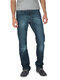

In [64]:
import matplotlib.pyplot as plt
from PIL import Image
img = Image.open("../data/myntradataset/images/39386.jpg").convert("RGB")
img

In [65]:
img = tsfm(img)
img

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [74]:
img = img.to(device)
logits = custom_model(img.unsqueeze(0))

In [75]:
_, preds = torch.max(logits, 1)
preds

tensor([1], device='cuda:0')

In [79]:
classes = train_data.classes
classes

['Accessories',
 'Apparel',
 'Footwear',
 'Free Items',
 'Home',
 'Personal Care',
 'Sporting Goods']

In [80]:
# this is the predicted class
classes[preds[0]]

'Apparel'